# Conceptual Test

purpose: classify PSK and GFSK signals

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
from lib import sig_gen

Loading BokehJS ...

In [17]:
sig = sig_gen.gfsk_gen(bt=0.5, mi=0.5, sps=50)
phase = np.diff(np.unwrap(np.angle(sig)))
fig = figure(plot_width=600, plot_height=300)
fig.line(np.arange(phase.size), phase/np.pi)
show(fig)

In [26]:
bt, span, sps = 0.5, 1, 50
gaus = sig_gen.gaussdesign(bt, span, sps)
msg = np.random.randint(0, 2, 32)
msg = np.array([0,1,0,1,0,1,0,1,0,1])
freq = msg*2-1.0
freq = sig_gen.upsample(freq, sps, zeros=False)
freq_gaus = np.convolve(freq, gaus)

fig = figure(plot_width=600, plot_height=300)
fig.line(np.arange(freq_gaus.size), freq_gaus)




show(fig)

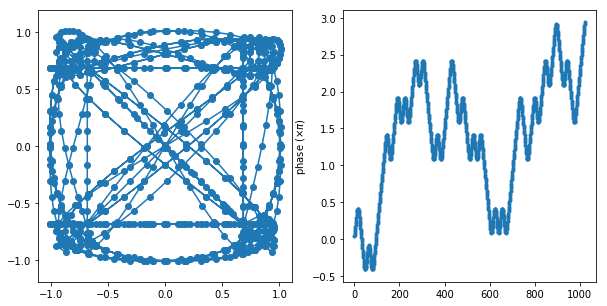

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sig = sig_gen.psk_gen()
ax[0].plot(sig.imag, sig.real, marker='o')
ax[0].axis('equal')

sig = sig_gen.gfsk_gen()
phase = np.unwrap(np.angle(sig))
ax[1].plot(phase/np.pi, marker='.')
plt.ylabel('phase ('r'$\times \pi$)')
plt.show()   

In [37]:
%timeit np.array([sig_gen.gfsk_gen() for x in range(10)])

4.59 ms ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
sig2 = np.vstack((sig, sig, sig))
sig2 = np.expand_dims(sig2, 1)[:, :, 0:-1: 4]

# sig2 = np.matlib.repmat(sig, 3, 1)
sig2.shape


(3, 1, 256)